In [2]:
length = 1  # m
g = 9.8  # m/s^2
theta_0 = 0.2  # rad
theta_dot_0 = 0.0  # rad/s
friction_constant_0 = 1.0  # s^-1
power_speed_0 = 3.13  # rad/s
power_0 = 0.2  # s^-2

## Oppgave 1: RK4
Satte opp RK4 ved å løse ligningen for vinkelakserelasjon.

In [3]:
import numpy as np


def pendulum_ode(
    t: float,
    state: tuple[float, float],
    power_speed: float = power_speed_0,
    friction_constant: float = friction_constant_0,
    power: float = power_0,
) -> np.ndarray[float, float]:
    """
    Calculates the right hand side of the differential equation for the pendulum.
    """
    theta, theta_dot = state
    theta_dot_dot = (
        -g / length * theta
        - friction_constant * theta_dot
        + power * np.sin(power_speed * t)
    )
    return np.array([theta_dot, theta_dot_dot])


def pendulum_ode_full(
    t: float,
    state: tuple[float, float],
    power_speed: float = power_speed_0,
    friction_constant: float = friction_constant_0,
    power: float = power_0,
) -> np.ndarray[float, float]:
    """
    Calculates the right hand side of the differential equation for the pendulum, without the small angle approximation.
    """
    theta, theta_dot = state
    theta_dot_dot = (
        -g / length * np.sin(theta)
        - friction_constant * theta_dot
        + power * np.sin(power_speed * t)
    )
    return np.array([theta_dot, theta_dot_dot])


def RK4_step(
    RHS: callable,
    vals: tuple[float, float],
    t: float,
    dt: float,
    power_speed: float = power_speed_0,
    friction_constant: float = friction_constant_0,
    power: float = power_0,
) -> np.ndarray[float, float]:
    """
    Calculates one step of the RK4-algorithm.

    RHS: (callable) function representing the right hand side of the differential equations
    vals: (numpy array) previous values of theta and omega, [theta, omega]
    t: (float) previous time
    dt: (float) timestep

    return: (array) next values [theta_next, omega_next]
    """
    k1 = RHS(
        t,
        vals,
        power_speed=power_speed,
        friction_constant=friction_constant,
        power=power,
    )
    k2 = RHS(
        t + dt / 2,
        vals + (dt / 2) * k1,
        power_speed=power_speed,
        friction_constant=friction_constant,
        power=power,
    )
    k3 = RHS(
        t + dt / 2,
        vals + (dt / 2) * k2,
        power_speed=power_speed,
        friction_constant=friction_constant,
        power=power,
    )
    k4 = RHS(
        t + dt,
        vals + dt * k3,
        power_speed=power_speed,
        friction_constant=friction_constant,
        power=power,
    )
    return vals + (dt / 6) * (k1 + (2 * k2) + (2 * k3) + k4)


def RK4_method(
    RHS: callable,
    theta_0: float,
    theta_dot_0: float,
    dt: float,
    T: float,
    power_speed: float = power_speed_0,
    friction_constant: float = friction_constant_0,
    power: float = power_0,
) -> tuple[np.ndarray[float], np.ndarray[float], np.ndarray[float]]:
    """
    Computes theta and w (omega).

    Parameters
    -----------
    RHS: RHS of the differential equation
    theta0: initial value of theta
    w0: initial value of omega
    dt: timestep
    T: max t

    return theta, w, t
    """

    t = np.arange(0, T + dt, dt)
    theta = np.zeros_like(t)
    w = np.zeros_like(t)
    theta[0], w[0] = theta_0, theta_dot_0
    for i in range(len(t) - 1):
        theta[i + 1], w[i + 1] = RK4_step(
            RHS,
            np.array([theta[i], w[i]]),
            t[i],
            dt,
            power_speed=power_speed,
            friction_constant=friction_constant,
            power=power,
        )

    return theta, w, t


def euler_cromer_approx(theta_0: float, theta_dot_0: float, dt: float, T: float):
    """
    Calculates angular displacement and angular velocity
    using the Euler-Cromer method
    """
    t = np.arange(0, T + dt, dt)
    theta, w = np.zeros_like(t), np.zeros_like(t)
    theta[0], w[0] = theta_0, theta_dot_0
    for i in range(len(t) - 1):
        theta_dot_dot = pendulum_ode(t[i], [theta[i], w[i]])[1]
        w[i + 1] = w[i] + theta_dot_dot * dt
        theta[i + 1] = theta[i] + w[i + 1] * dt
    return theta, w, t

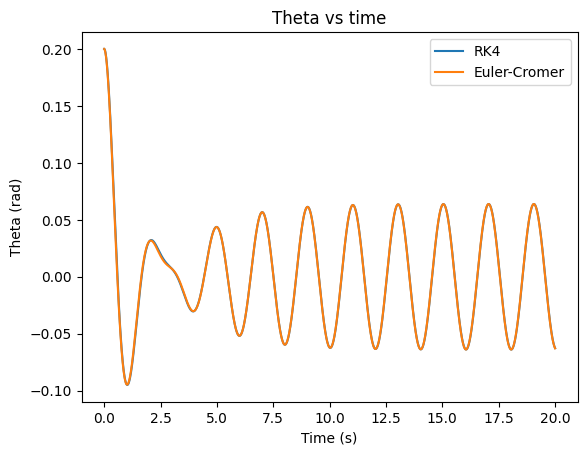

In [4]:
import matplotlib.pyplot as plt

theta, w, t = RK4_method(pendulum_ode, theta_0, theta_dot_0, 0.01, 20)
theta_ec, w_ec, t_ec = euler_cromer_approx(theta_0, theta_dot_0, 0.01, 20)
plt.plot(t, theta)
plt.plot(t_ec, theta_ec)
plt.legend(["RK4", "Euler-Cromer"])
plt.title("Theta vs time")
plt.xlabel("Time (s)")
plt.ylabel("Theta (rad)")
plt.show()

## Oppgave 2: Konvergens

Kovergenstest av både euler-cromer og RK4. \
Tester gjennomsnittlig forskjell fra forrige forsøk med synkende dt. \
Ser fra dette at dt = 0.01 var mer enn tilstrekkelig for både euler-cromer og RK4 for våre skalaer. Vi ser også at RK4 konvergerer mye raskere enn euler-cromer.

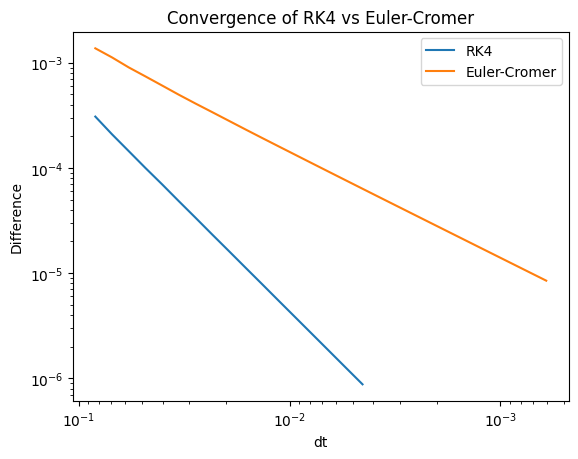

In [5]:
def function_diff(
    v_1: np.ndarray[float],
    t_1: np.ndarray[float],
    v_2: np.ndarray[float],
    t_2: np.ndarray[float],
) -> float:
    """
    Function to calculate the difference between two vectors
    Iterates over the time values and compares the values at the same time
    If no value is found at the same time, it linearly interpolates the value
    """

    def get_value(v: np.ndarray[float], t: np.ndarray[float], t_val: float) -> float:
        idx = np.argmin(np.abs(t - t_val))
        diff = t[idx] - t_val
        dt = t[1] - t[0]
        interp_factor = np.abs(diff / dt)

        if diff == 0:
            return v[idx]
        if diff > 0:
            return v[idx] - interp_factor * (v[idx] - v[idx - 1])
        else:
            return v[idx] + interp_factor * (v[idx + 1] - v[idx])

    if len(t_1) > len(t_2):
        ts = t_1
    else:
        ts = t_2

    diffs = []
    for t in ts[1:-1]:
        v_1_val = get_value(v_1, t_1, t)
        v_2_val = get_value(v_2, t_2, t)
        diff = np.abs(v_1_val - v_2_val)
        diffs.append(diff)
    return np.mean(diffs)


def convergence_test_RK4(tol: float = 1e-3) -> tuple[list[float], list[float]]:
    """
    Function to test the convergence of the RK4-method
    """
    log_scale = 1.2
    theta, w, t = RK4_method(pendulum_ode, theta_0, theta_dot_0, 0.1, 20)
    theta_old = theta
    t_old = t
    dts = [0.1 / log_scale]
    diffs = []
    while True:
        theta, w, t = RK4_method(pendulum_ode, theta_0, theta_dot_0, dts[-1], 20)
        diffs.append(function_diff(theta, t, theta_old, t_old))
        if diffs[-1] < tol:
            break
        theta_old = theta
        t_old = t
        dts.append(dts[-1] / log_scale)
    return dts, diffs


def convergence_test_euler_cromer(tol: float = 1e-3) -> tuple[list[float], list[float]]:
    """
    Function to test the convergence of the Euler-Cromer
    """
    log_scale = 1.2
    theta, w, t = euler_cromer_approx(theta_0, theta_dot_0, 0.1, 10)
    theta_old = theta
    t_old = t
    dts = [0.1 / log_scale]
    diffs = []
    while True:
        theta, w, t = euler_cromer_approx(theta_0, theta_dot_0, dts[-1], 10)
        diffs.append(function_diff(theta, t, theta_old, t_old))
        if diffs[-1] < tol:
            break
        theta_old = theta
        t_old = t
        dts.append(dts[-1] / log_scale)
    return dts, diffs


dts, diffs = convergence_test_RK4(1e-6)
dts_ec, diffs_ec = convergence_test_euler_cromer(1e-5)
plt.plot(dts, diffs)
plt.plot(dts_ec, diffs_ec)
plt.legend(["RK4", "Euler-Cromer"])
plt.title("Convergence of RK4 vs Euler-Cromer")
plt.xlabel("dt")
plt.ylabel("Difference")
plt.xscale("log")
plt.yscale("log")
plt.gca().invert_xaxis()
plt.show()

## Oppgave 3: Drivkraftfrekvens

Her ser vi tydelig at vinkelutslaget blir størst når drivkraftfrekvensen er nærme resonansfrekvensen til systemet. \
Her er resonansfrekvensen til systemet relativt nærme $\sqrt{\frac{g}{l}}$, ettersom friksjonskonstanten er ganske lav.

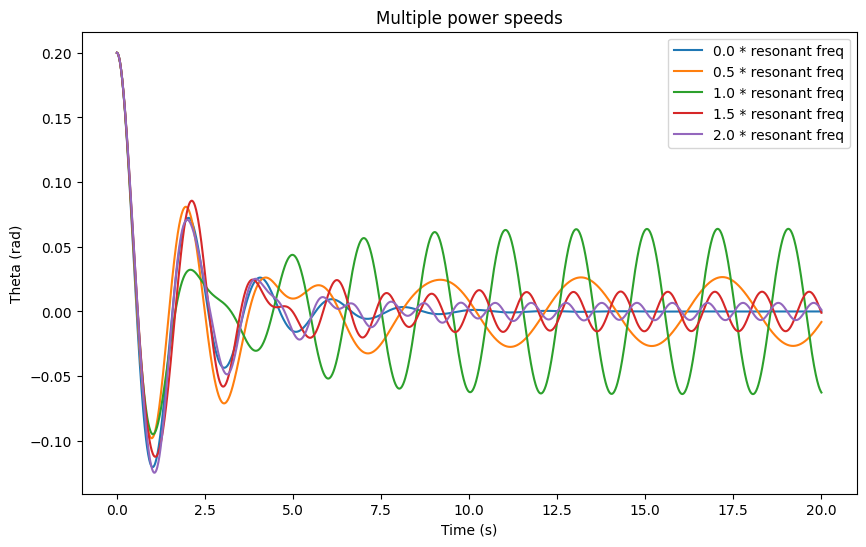

In [6]:
# power_speed_0 = np.sqrt(g/length)
power_speeds = np.linspace(0, 2, 5) * 3.13
plt.figure(figsize=(10, 6))
for power_speed in power_speeds:
    theta, w, t = RK4_method(
        pendulum_ode,
        theta_0,
        theta_dot_0,
        0.01,
        20,
        power_speed=power_speed,
        friction_constant=1,
    )
    plt.plot(t, theta)
plt.legend([f"{s} * resonant freq" for s in np.linspace(0, 2, 5)])
plt.title("Multiple power speeds")
plt.xlabel("Time (s)")
plt.ylabel("Theta (rad)")
plt.show()

## Oppgave 4: Friksjonsparameter 

Her plottes theta for ulike friksjonsverdier, uten noe drivkraft. \
Maksimalverdien på andre bølgetopp er også lagt inn. \
Man kan da se tydelig at den naturlige frekvensen til systemet blir lavere. 


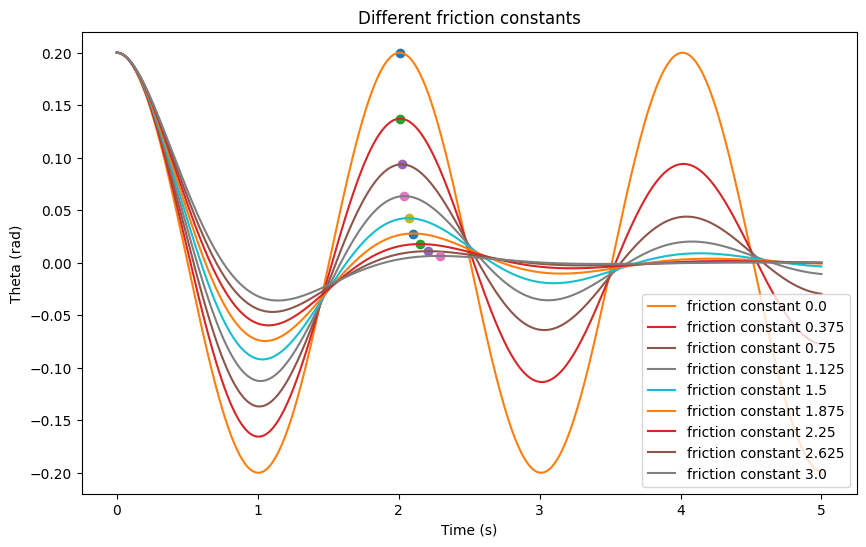

In [7]:
friction_constants = np.linspace(0, 3, 9)
plt.figure(figsize=(10, 6))
for friction_constant in friction_constants:
    theta, w, t = RK4_method(
        pendulum_ode,
        theta_0,
        theta_dot_0,
        0.01,
        5,
        friction_constant=friction_constant,
        power_speed=0,
    )
    time_index = np.where(t > 2)[0][0]
    thetas = theta[time_index:]
    max_theta = np.max(thetas)
    index = np.where(thetas == max_theta)[0][0]
    plt.plot(t[time_index + index], max_theta, "o")
    plt.plot(t, theta, label=f"friction constant {friction_constant}")
plt.legend()
plt.title("Different friction constants")
plt.xlabel("Time (s)")
plt.ylabel("Theta (rad)")
plt.show()

## Oppgave 5: Demping

Ved å sette friksjonsparameteren til 2*vinkelfrekvensen til systemet uten demping får vi kritisk demping. \
Friksjonsparametre over dette gir overkritisk og under gir underkritisk.

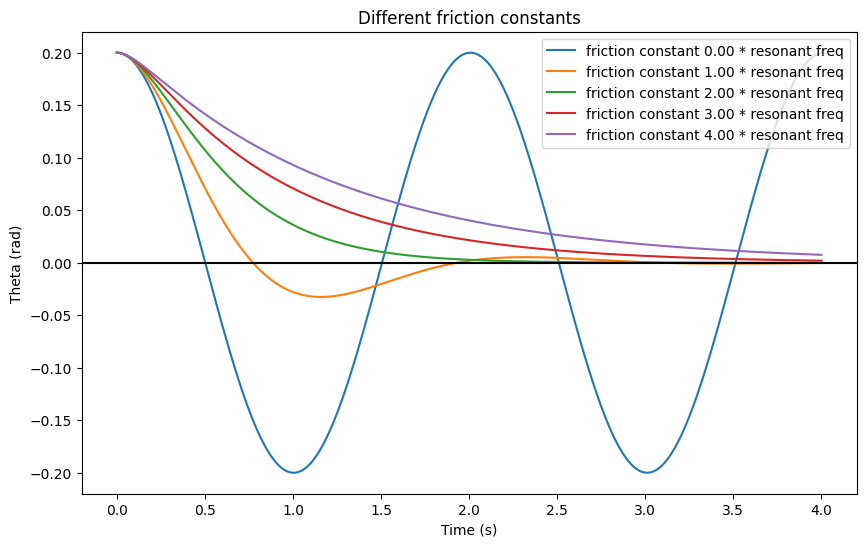

In [8]:
pendulum_freq = np.sqrt(g / length)
friction_constants = np.linspace(0, 4, 5) * pendulum_freq
plt.figure(figsize=(10, 6))
for friction_constant in friction_constants:
    theta, w, t = RK4_method(
        pendulum_ode,
        theta_0,
        theta_dot_0,
        0.01,
        4,
        friction_constant=friction_constant,
        power_speed=0,
    )
    plt.plot(
        t,
        theta,
        label=f"friction constant {friction_constant/pendulum_freq:.2f} * resonant freq",
    )
plt.legend()
plt.title("Different friction constants")
plt.xlabel("Time (s)")
plt.ylabel("Theta (rad)")
plt.axline((0, 0), slope=0, color="black")
plt.show()

## Oppgave 6: uten småvinkelapprox

a)
Ser at uten småvinkelapproksimasjonen er det en liten feil.

b)
Den letteste måten å få kaotiske bevegelser på er å sette drivkraftens vinkelfrekvense nerme resonans og ha ganske mye kraft.

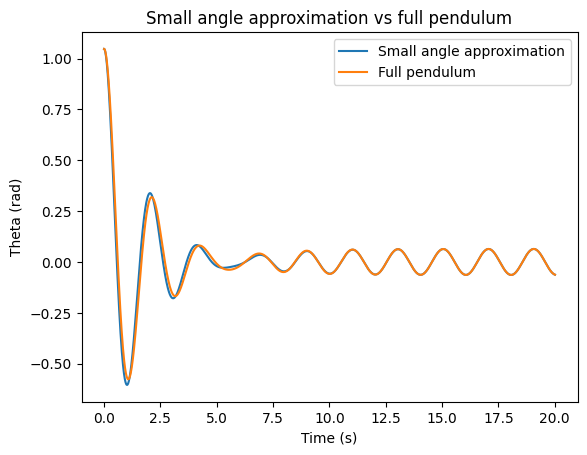

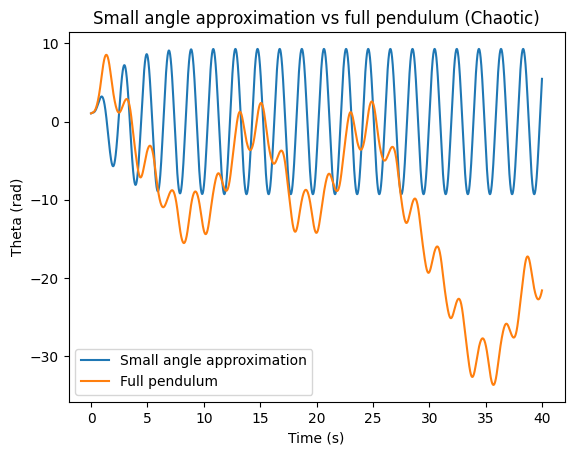

In [9]:
theta_60 = np.pi / 3
theta_dot = 0
theta_1, w_1, t_1 = RK4_method(pendulum_ode, theta_60, theta_dot, 0.01, 20)
theta_2, w_2, t_2 = RK4_method(pendulum_ode_full, theta_60, theta_dot, 0.01, 20)

plt.plot(t_1, theta_1)
plt.plot(t_2, theta_2)
plt.legend(["Small angle approximation", "Full pendulum"])
plt.title("Small angle approximation vs full pendulum")
plt.xlabel("Time (s)")
plt.ylabel("Theta (rad)")
plt.show()


theta_60 = np.pi / 3
theta_dot = 1
power = 30
power_speed = 3.2
friction_constant = 1
theta_1, w_1, t_1 = RK4_method(
    pendulum_ode,
    theta_60,
    theta_dot,
    0.01,
    40,
    power_speed=power_speed,
    friction_constant=friction_constant,
    power=power,
)
theta_2, w_2, t_2 = RK4_method(
    pendulum_ode_full,
    theta_60,
    theta_dot,
    0.01,
    40,
    power_speed=power_speed,
    friction_constant=friction_constant,
    power=power,
)

plt.plot(t_1, theta_1)
plt.plot(t_2, theta_2)
plt.legend(["Small angle approximation", "Full pendulum"])
plt.title("Small angle approximation vs full pendulum (Chaotic)")
plt.xlabel("Time (s)")
plt.ylabel("Theta (rad)")
plt.show()